## In this notebook we create our model and evaluate it

**K-means Steps:**

1. Run PCA on the preprocessed data

2. Use the elbow method to find a k value

3. Run kmeans with the dataframe created in the PCA step

**HDBSCAN Steps:**

1. Run UMAP on the preprocessed data

2. Run HDBSCAN with the dataframe created in the UMAP step


# Set up and load data

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from sklearn.cluster import KMeans, HDBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from umap import UMAP

RANDOM_STATE = 42

C:\Users\User\anaconda3\envs\music-recommender\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# If using a local environment
data_path = "data/"

In [3]:
# # If using a collab environment
# from google.colab import drive
#
# drive.mount('/content/drive')
#
# data_path = "/content/drive/MyDrive/DSE/DSE 220 Final Project/Data/"

In [4]:
# Input dataframe path
processed_users_path = data_path + "users_cleaned_encoded_500k_df.parquet"
# Where the processed dataframe will be saved
users_clustered_path_parquet = data_path + "data/users_clusters_500k_df.parquet"

In [5]:
# Polars is faster at loading large datasets
users_polars_df = pl.read_parquet(processed_users_path)

In [6]:
users_df_orig = users_polars_df.to_pandas(use_pyarrow_extension_array=True)

In [7]:
len(users_df_orig)

503333

In [8]:
if len(users_df_orig) <= 600000:
    users_df = users_df_orig.copy()
else:
    # testing
    users_df = (users_df_orig.copy().sample(
        n=100000,
        random_state=RANDOM_STATE
    ))

In [9]:
# Drop all one hot encoded fav artist columns (takes too long to run)
users_df = users_df[users_df.columns.drop(list(users_df.filter(regex='fav_artist_')))]
len(users_df)

503333

## Dimensional Reduction

### PCA for k-means
Run PCA and capture at least 90% of the variance.

In [10]:
# Want to keep at least 90% of the variance
transformer = PCA(n_components=0.9, random_state=RANDOM_STATE)

In [11]:
# Drop user_id as it will not have relevance for clustering
X = users_df.drop(columns=['user_id'])

In [12]:
X_pca = transformer.fit_transform(X)

In [13]:
# Create new columns for each of the components
num_cols = X_pca.shape[1]
X_pca_df = pd.DataFrame(
    X_pca,
    columns=[f'PC{i + 1}' for i in range(num_cols)]
)
X_pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,-1.812312,-1.261226,1.102451,0.146593,0.448394,-0.031961,0.545473,0.322066
1,-1.432829,-1.234230,0.421104,1.443372,0.478808,0.094849,-0.331160,-0.897230
2,-0.257813,-1.326893,1.017613,-1.127739,-0.947442,-0.043776,0.569436,0.456340
3,-0.404203,-1.613138,0.248728,-0.608930,-0.047729,0.095073,0.558969,-0.280264
4,1.526359,-0.692742,-1.462596,0.480453,-0.680331,0.638585,-0.381671,-0.528111


In [14]:
print("Explained variance ratio by each component:", transformer.explained_variance_ratio_)
print("Total variance captured:", np.sum(transformer.explained_variance_ratio_))

Explained variance ratio by each component: [0.37748306 0.23787433 0.09994937 0.07292104 0.06597858 0.02214788
 0.02010576 0.01546631]
Total variance captured: 0.9119263275401734


### UMAP for HDBSCAN

In [15]:
# hdbscan = O(n^2) = takes a long time to run on full dataset
X_hdbscan = users_df.drop(columns=['user_id'])

In [ ]:
print("Starting UMAP for HDBSCAN...")
start_time = time.time()
# works better than pca for hdbscan
X_umap = UMAP(
    n_components=15,  # number of dimensions to reduce to
    n_neighbors=50,  # number of nearest neighbors to use in manifold approximation
    min_dist=0.0,  # how tightly packed the manifold is within the local neighborhood
).fit_transform(X_hdbscan)

end_time = time.time()
print(f"UMAP completed in {end_time - start_time:.2f} seconds")

Starting UMAP for HDBSCAN...


In [ ]:
print("Shape:", X_umap.shape)
X_umap

Shape: (503333, 15)


array([[6.033246 , 4.93607  , 6.171909 , ..., 7.562721 , 5.7734723,
        4.965068 ],
       [5.746187 , 7.7403965, 4.1361365, ..., 3.901343 , 5.7461596,
        4.3708262],
       [3.5425177, 3.648495 , 7.4012804, ..., 4.5546017, 3.8384895,
        7.3717637],
       ...,
       [3.4914865, 3.3210702, 6.9875965, ..., 4.707461 , 4.147755 ,
        6.9253864],
       [3.8810954, 3.6033683, 7.128893 , ..., 5.131601 , 3.7948744,
        6.7076273],
       [4.537747 , 4.71454  , 4.8343506, ..., 4.0244837, 5.7347355,
        4.2590423]], shape=(503333, 15), dtype=float32)

# Model Creation & Evaluation

## Model 1: K Means

### Picking K: Elbow method
Use the elbow method and a plot to see how many clusters we may want to use.

In [21]:
n_clusters = 30  # how many clusters to test
k_values = range(1, n_clusters + 1)
inertia_values = []
# Store the number of data points within each cluster for every k tested
kmeans_comp_arr = np.zeros((n_clusters, n_clusters))

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init='auto')
    kmeans_fitted = kmeans.fit(X_pca_df)
    inertia_values.append(kmeans.inertia_)
    # Unique cluster labels assigned to each data point, counts points in cluster
    cluster_id, counts = np.unique(kmeans_fitted.labels_, return_counts=True)
    for i in range(len(cluster_id)):
        kmeans_comp_arr[k - 1, cluster_id[i]] = counts[i]

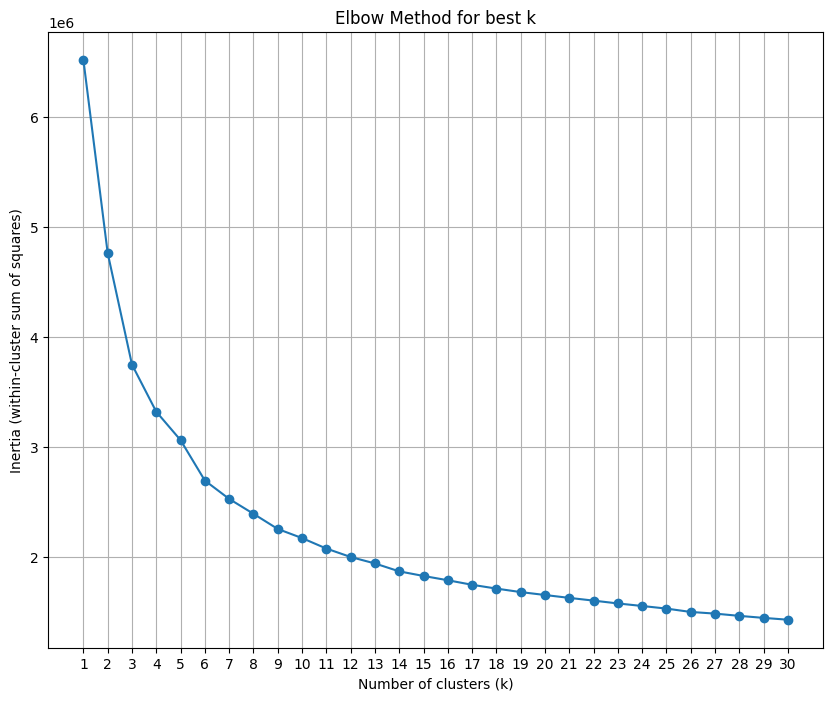

In [22]:
# Plot the elbow
plt.figure(figsize=(10, 8))
plt.plot(k_values, inertia_values, marker='o')
plt.xticks(k_values)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (within-cluster sum of squares)')
plt.title('Elbow Method for best k')
plt.grid(True)
plt.show()

We inspect the cluster size distribution for k =1 through k = 30. We notice a change in slope at k=9. Even though the elbow is around k= 8 and 9, we notice that a giant cluster dominates at that level, and the other clusters are also huge. So we look at higher k values. We notice that the largest cluster sizes start dropping below 60K, i.e., 12.5% or one-eighth of the entire dataset at k = 24. K =24, 25 and 26 are pretty similar, with the smallest clusters of size 1800, 1300 and 1400, so we chose k = 26, where the smallest cluster is in the middle of the range for the three k values.

<Figure size 1500x800 with 0 Axes>

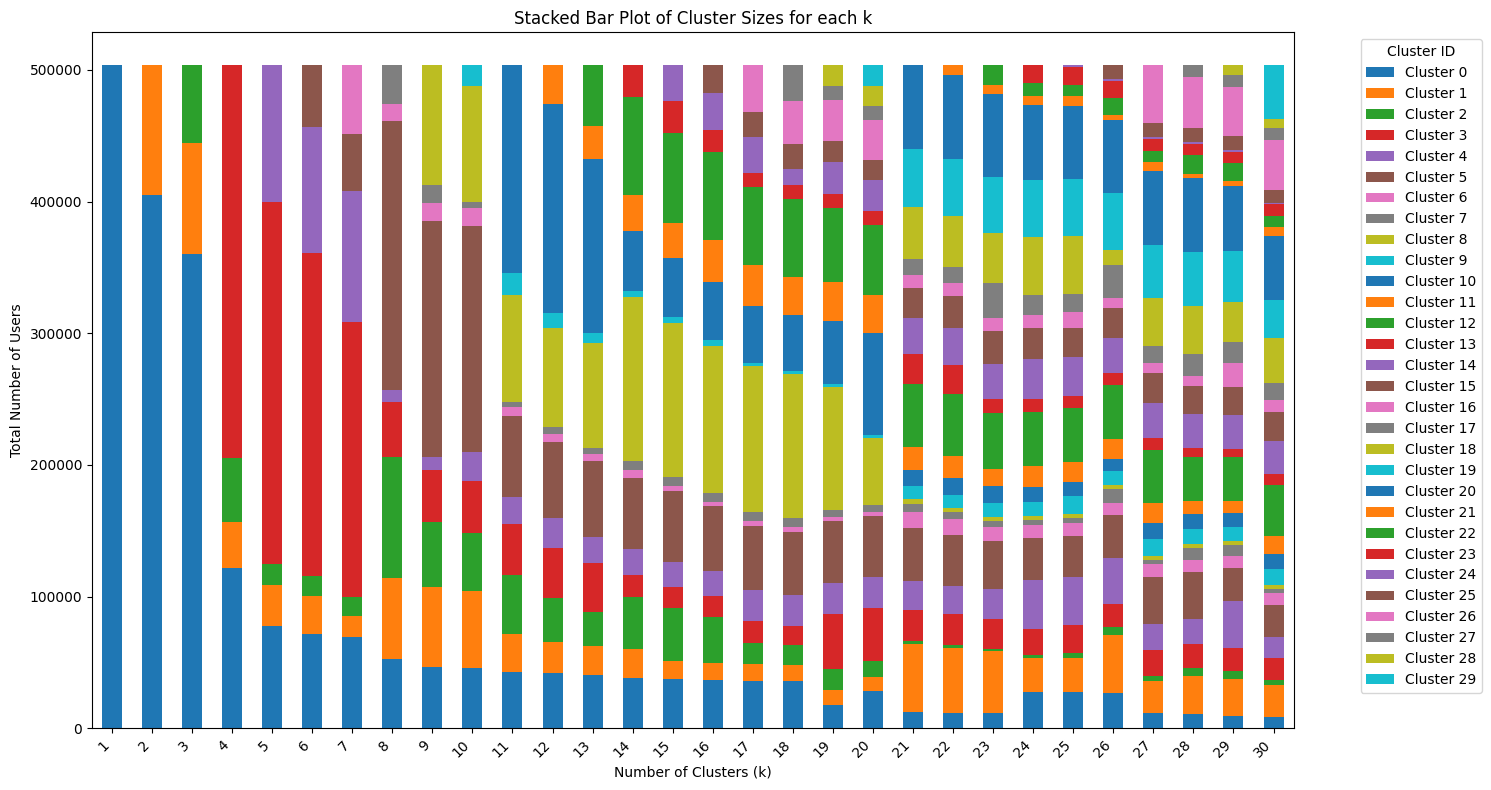

In [38]:
df_for_stacked_plot = pd.DataFrame(kmeans_comp_arr,
                                   index=k_values,
                                   columns=[f'Cluster {i}' for i in range(n_clusters)])

plt.figure(figsize=(15, 8))
df_for_stacked_plot.plot(kind='bar', stacked=True, figsize=(15, 8))  #, colormap='tab20b')
plt.title('Stacked Bar Plot of Cluster Sizes for each k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Total Number of Users')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Cluster ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [39]:
# Display the sizes for all the cluster sizes
kmeans_comp_df = pd.DataFrame(
    kmeans_comp_arr,
    index=k_values,
    columns=[f'Cluster {i}' for i in range(n_clusters)]
)

print("Distribution of data points per cluster for each k (rows = k, columns = cluster ID):")
display(kmeans_comp_df)

Distribution of data points per cluster for each k (rows = k, columns = cluster ID):


,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,...,Cluster 20,Cluster 21,Cluster 22,Cluster 23,Cluster 24,Cluster 25,Cluster 26,Cluster 27,Cluster 28,Cluster 29
1,503333.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,404676.0,98657.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,360523.0,83801.0,59009.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,122053.0,34786.0,48615.0,297879.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,77752.0,30673.0,16531.0,274735.0,103642.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,71656.0,28464.0,15563.0,244953.0,96277.0,46420.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,68954.0,16106.0,14981.0,208600.0,99115.0,43204.0,52373.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,52234.0,61767.0,91698.0,41916.0,9118.0,204307.0,13352.0,28941.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,46771.0,60325.0,49234.0,40000.0,9642.0,179528.0,13536.0,13472.0,90825.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,45893.0,58312.0,44324.0,39516.0,22025.0,171640.0,13410.0,4251.0,88122.0,15840.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


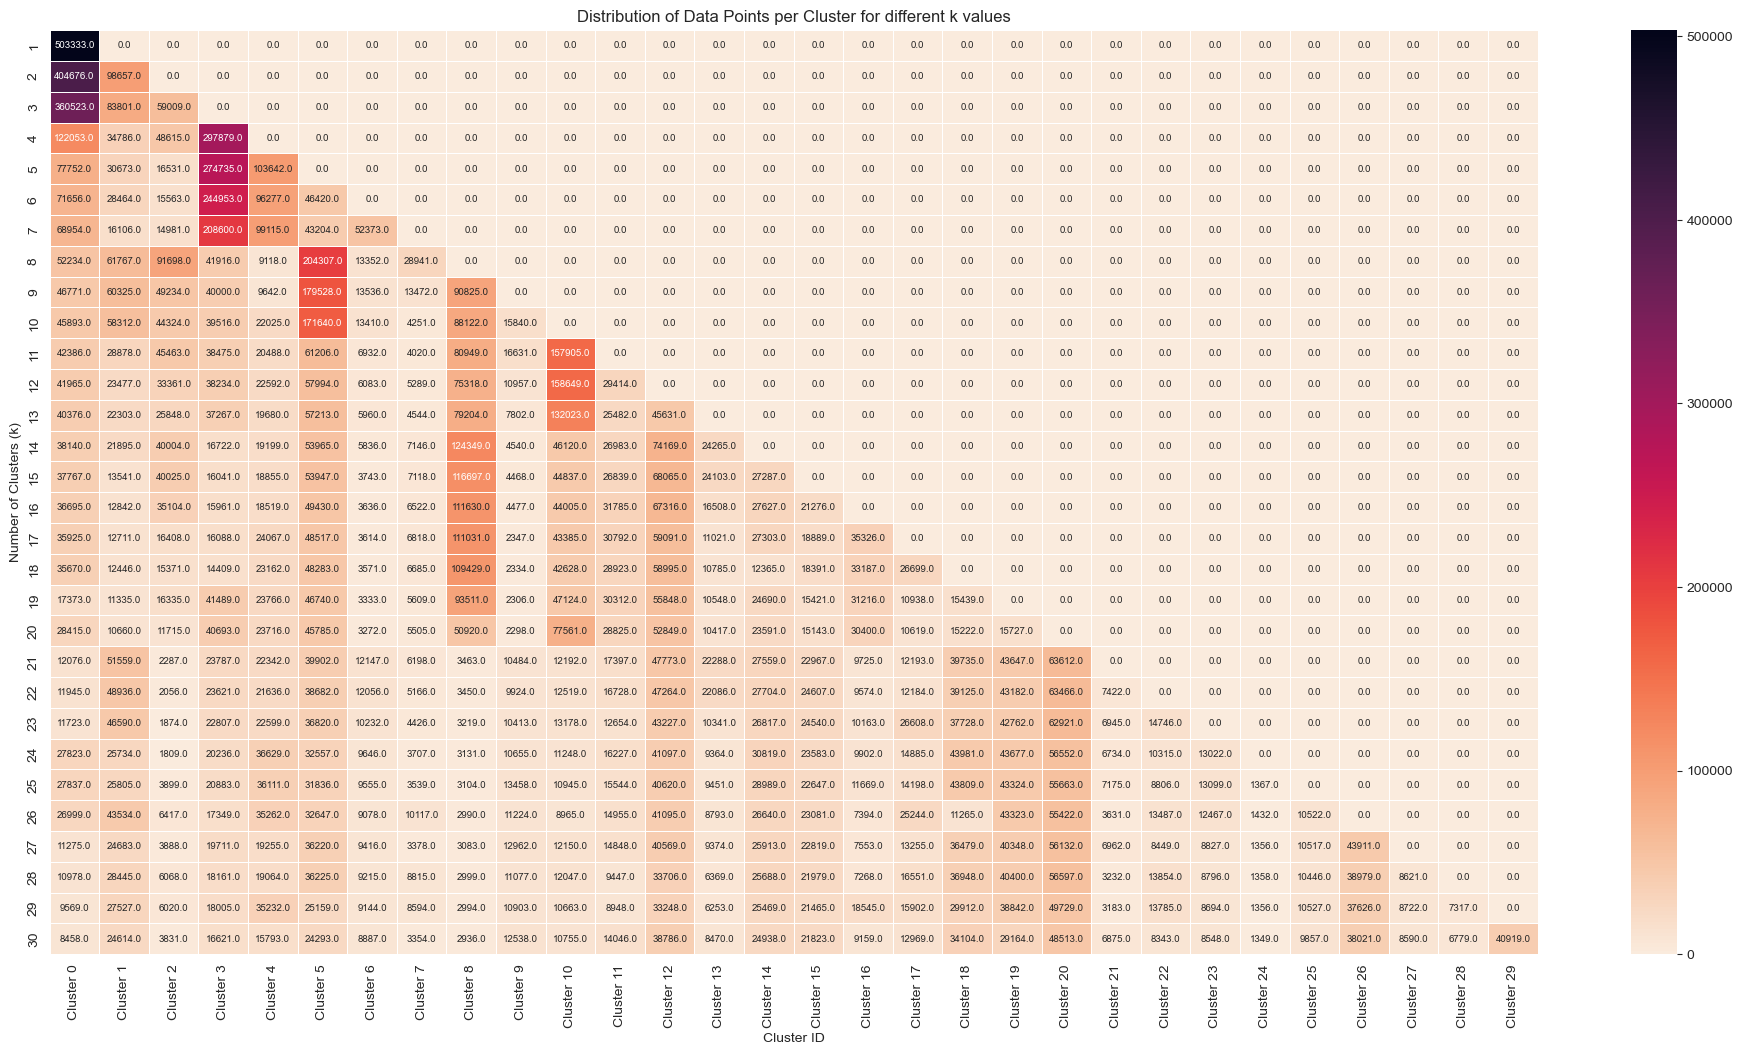

In [ ]:
plt.figure(figsize=(24, 12))
sns.heatmap(kmeans_comp_df,
            annot=True,
            fmt='.1f',
            cmap='rocket_r',
            annot_kws={'fontsize': 7},
            linewidths=0.5
            )
plt.title('Distribution of Data Points per Cluster for different k values')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Clusters (k)')
plt.show()

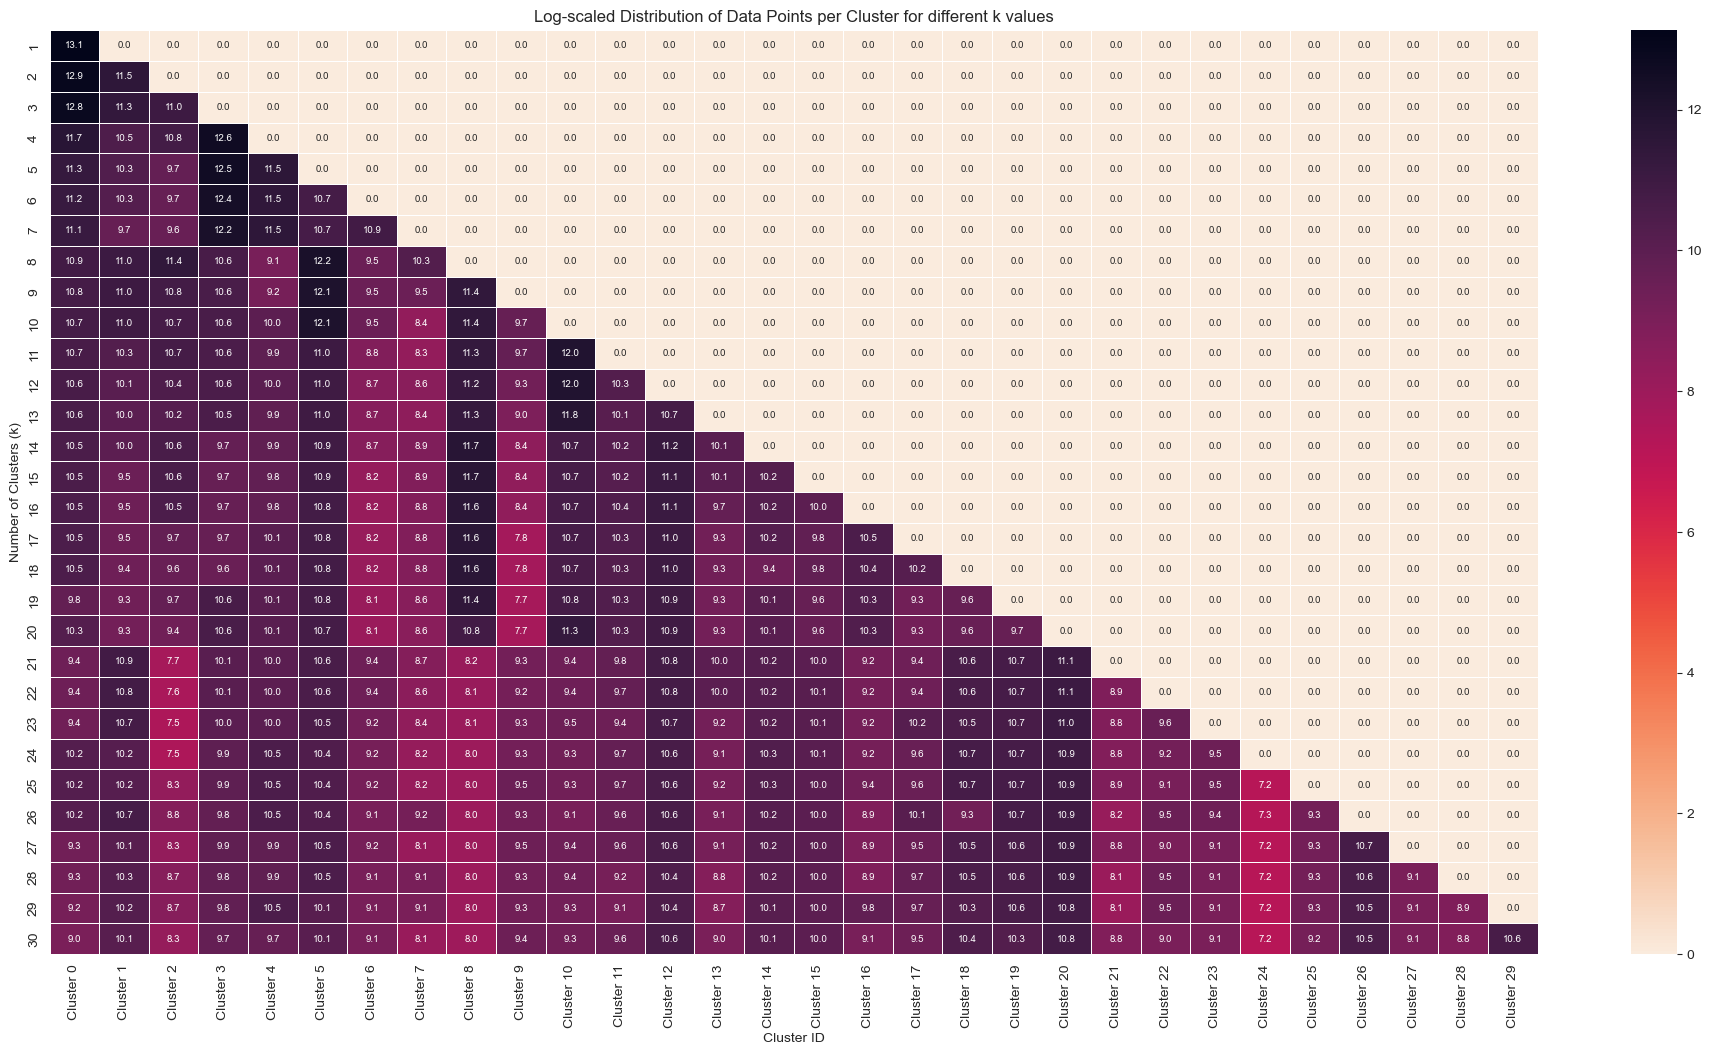

In [ ]:
plt.figure(figsize=(24, 12))
sns.heatmap(np.log1p(kmeans_comp_df), annot=True, fmt='.1f', cmap='rocket_r', annot_kws={'fontsize': 7}, linewidths=0.5)
plt.title('Log-scaled Distribution of Data Points per Cluster for different k values')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Clusters (k)')
plt.show()

### Run k-means

In [40]:
# Based on the elbow, we observe a leveling out at k=9, however, we choose k=26 based on reasoning shared above
k_num_clusters = 26

In [41]:
kmeans = KMeans(n_clusters=k_num_clusters, random_state=RANDOM_STATE, n_init='auto')
kmeans_fitted = kmeans.fit(X_pca_df)
inertia_values.append(kmeans.inertia_)
np.unique(kmeans_fitted.labels_, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25], dtype=int32),
 array([26999, 43534,  6417, 17349, 35262, 32647,  9078, 10117,  2990,
        11224,  8965, 14955, 41095,  8793, 26640, 23081,  7394, 25244,
        11265, 43323, 55422,  3631, 13487, 12467,  1432, 10522]))

### Evaluate k-means

In [42]:
users_clustered_df = users_df.copy()
users_clustered_df['kmeans_cluster'] = kmeans_fitted.labels_

In [43]:
# Compute Silhouette Score to measure cluster similarity
# It's costly to run, so we sample with 50k
sample = np.random.choice(len(X_pca_df), size=50000, replace=False)
score = silhouette_score(X_pca_df.iloc[sample], kmeans_fitted.labels_[sample])
print("Silhouette Score (sample):", score)

Silhouette Score (sample): 0.13353715378347436


In [58]:
# For PCA Plots
users_columns_pca = X_pca_df.columns
users_centroids_pca = kmeans_fitted.cluster_centers_
users_kmeans_centroids_df = pd.DataFrame(columns=users_columns_pca, data=users_centroids_pca)
users_kmeans_centroids_df['kmeans_cluster'] = users_kmeans_centroids_df.index

users_df_kmeans_clusters = X_pca_df.copy()
users_df_kmeans_clusters['kmeans_cluster'] = kmeans_fitted.labels_
users_df_kmeans_clusters['user_id'] = users_df['user_id']

In [45]:
users_kmeans_centroids_df.head(5)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,kmeans_cluster
0,-1.426170,-0.221403,0.155273,1.940834,-0.412015,-0.075360,-0.037249,-0.011302,0
1,-0.208581,-0.794736,0.585067,-0.161195,-0.337168,0.068508,0.109581,0.061580,1
2,6.001937,-1.293422,-0.663823,0.733704,2.479210,0.010170,-0.054885,-0.058289,2
3,-0.280403,3.234285,0.349689,-0.524781,0.249115,-0.031716,-0.023245,-0.035749,3
4,-1.815747,-0.659162,-1.473871,-0.160036,-0.108600,0.091353,0.009853,-0.000560,4


In [46]:
# For visualizing using original features
users_df_clusters_orig = users_df.copy()
users_df_clusters_orig['kmeans_cluster'] = kmeans_fitted.labels_
users_df_clusters_orig['user_id'] = users_df['user_id']

In [47]:
users_df_kmeans_clusters['kmeans_cluster'].value_counts().sort_index()

,count
kmeans_cluster,
0,26999
1,43534
2,6417
3,17349
4,35262
5,32647
6,9078
7,10117
8,2990


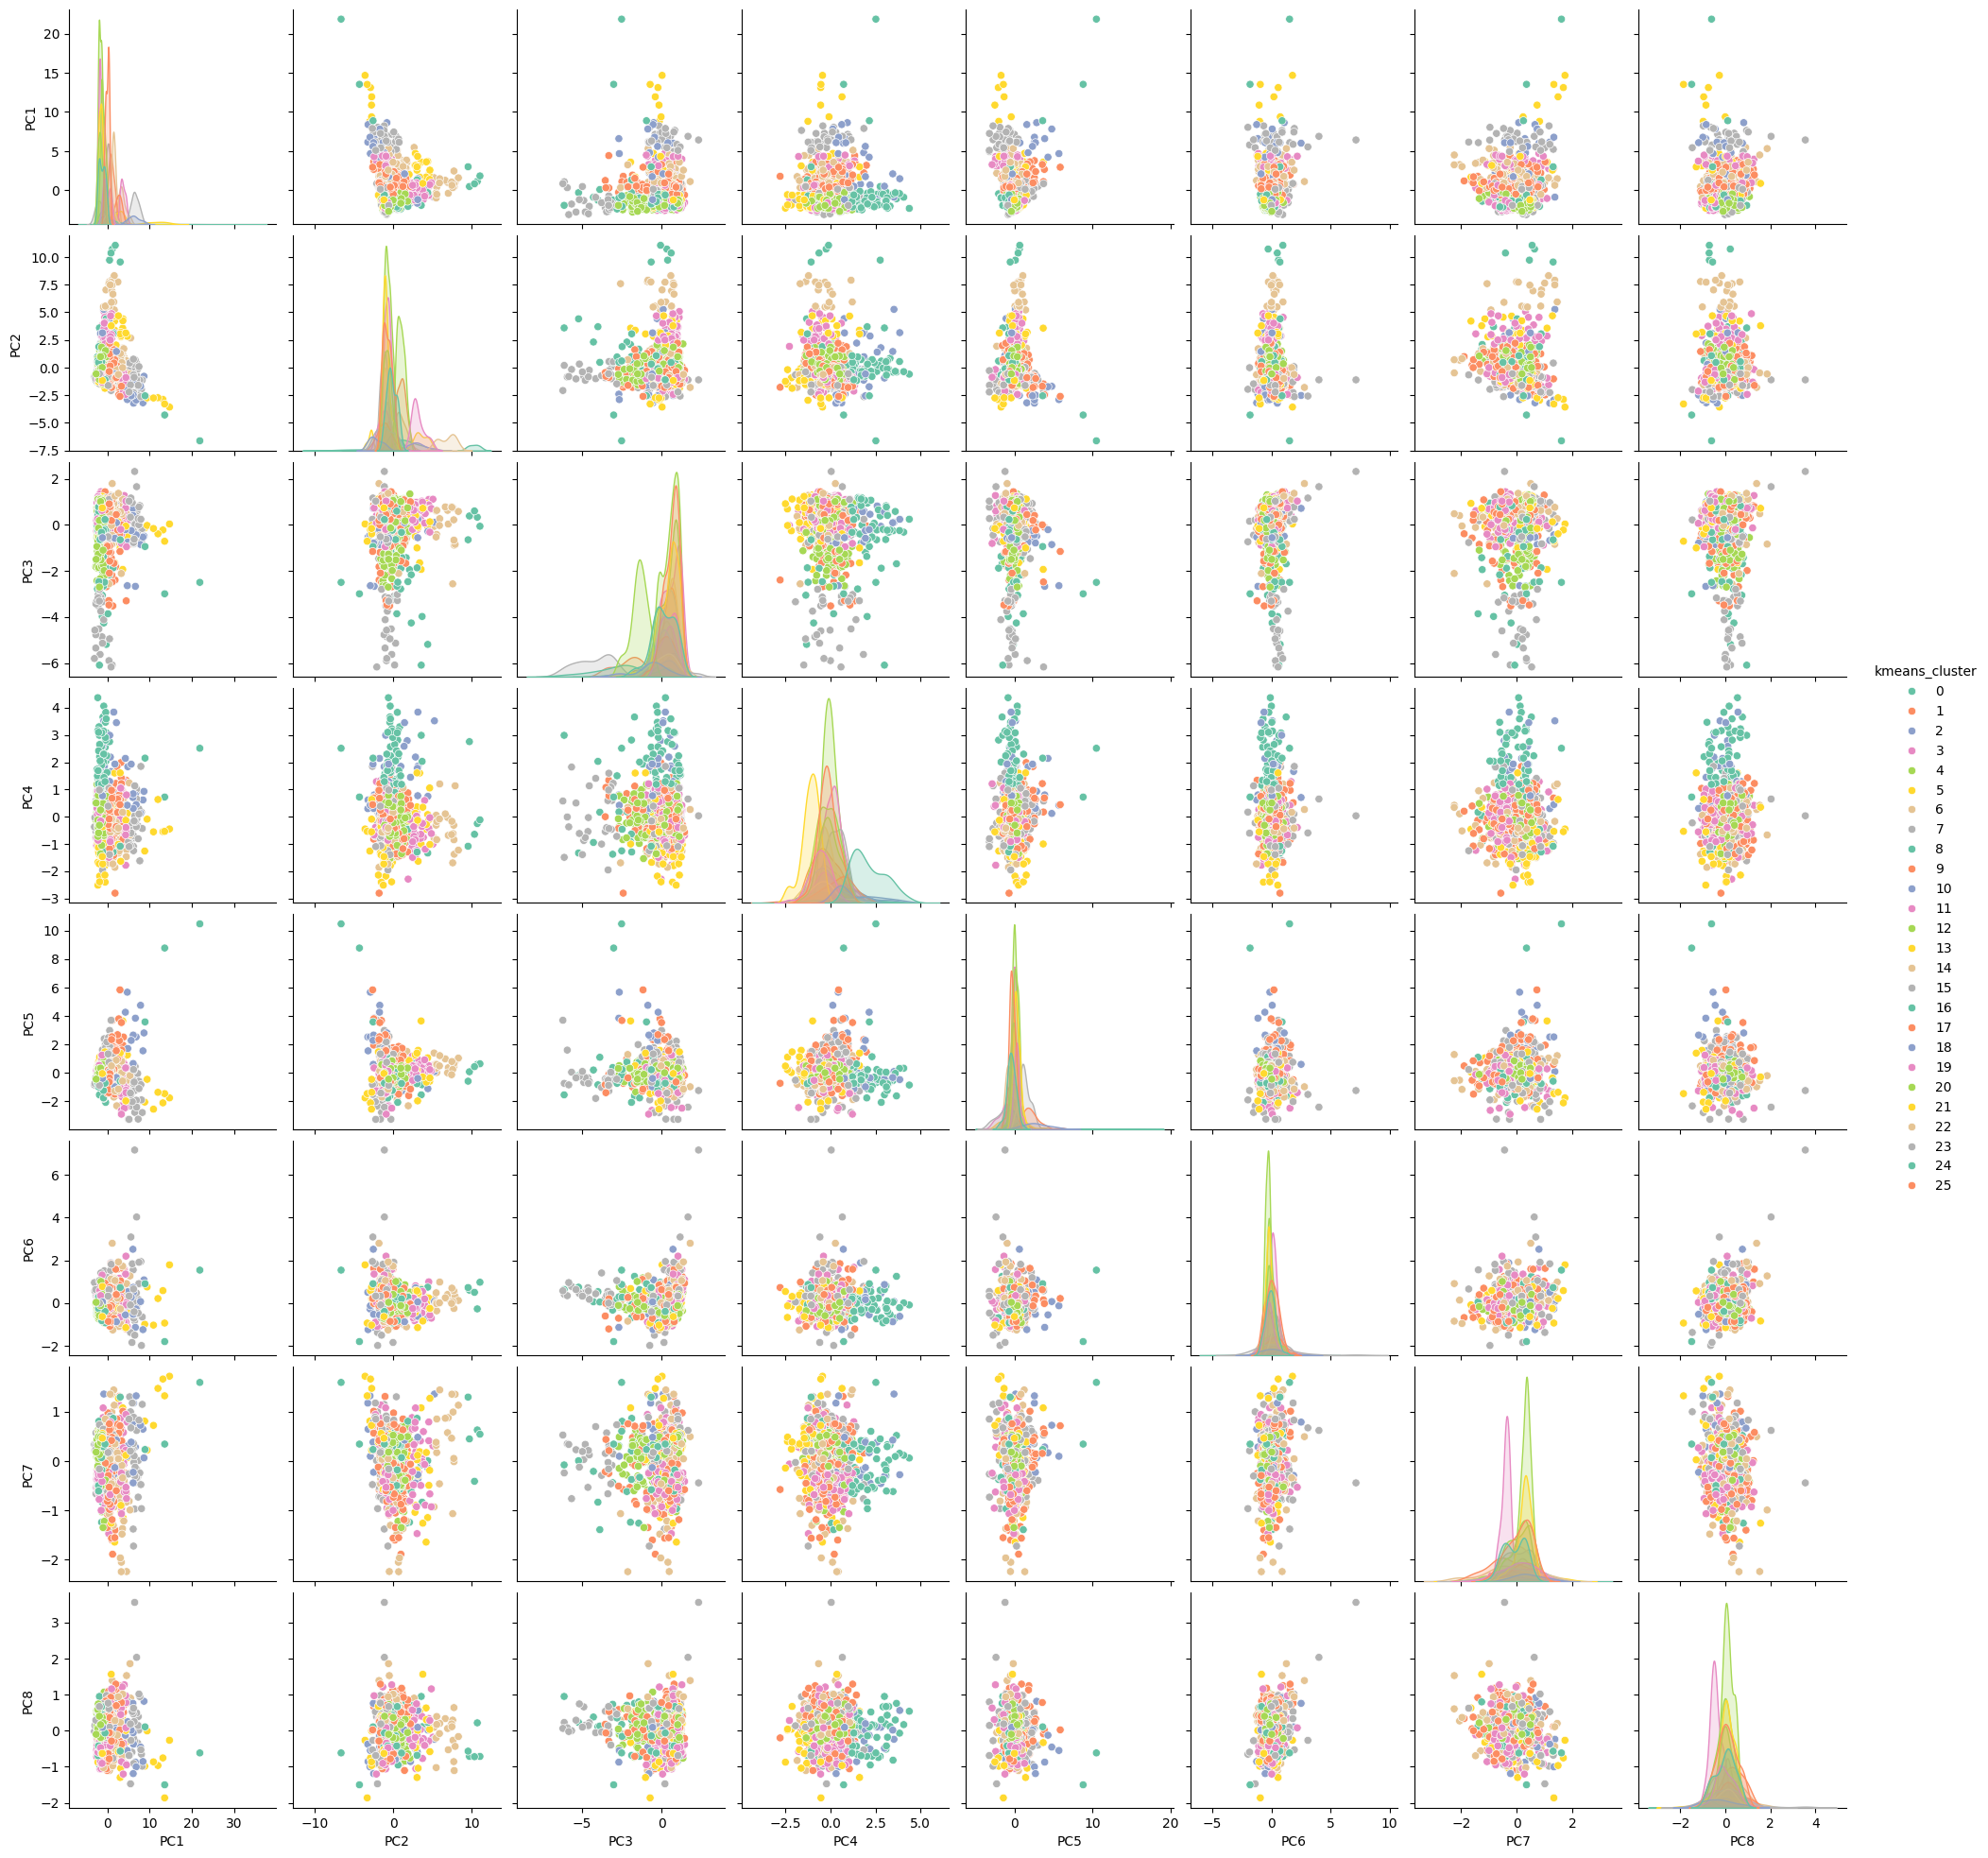

In [48]:
# How are clusters distinguished across different PC features?
sns.pairplot(
    hue='kmeans_cluster',
    palette='Set2',
    data=users_df_kmeans_clusters.sample(
        n=1000,
        random_state=RANDOM_STATE
    )
)

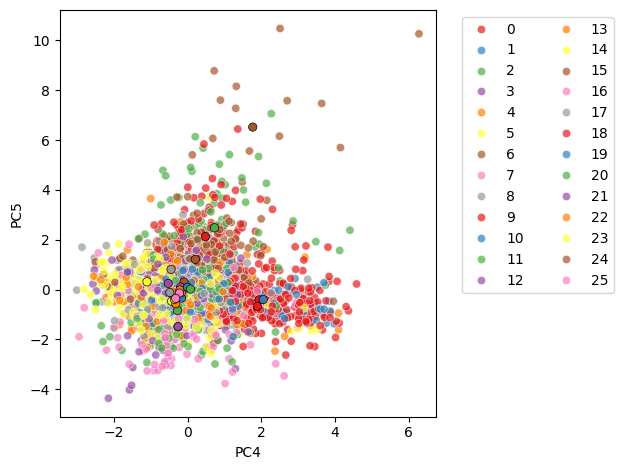

In [87]:
# Inspect a designated pc space more closely (look at pairplots for general overview)
# Also shows the centroids
variable_pairs = ['PC4', 'PC5']

# Plotting the results
sns.scatterplot(
    x=variable_pairs[0],
    y=variable_pairs[1],
    hue='kmeans_cluster',
    palette='Set1',
    alpha=0.7,
    data=users_df_kmeans_clusters.sample(
        n=5000,
        random_state=RANDOM_STATE
    )
)

sns.scatterplot(
    x=variable_pairs[0],
    y=variable_pairs[1],
    hue='kmeans_cluster',
    palette='Set1',
    markers=1000,
    alpha=1,
    edgecolor="black",
    data=users_kmeans_centroids_df,
    legend=False
)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
plt.tight_layout()
plt.show()

In [60]:
users_kmeans_centroids_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,kmeans_cluster
0,-1.426170,-0.221403,0.155273,1.940834,-0.412015,-0.075360,-0.037249,-0.011302,0
1,-0.208581,-0.794736,0.585067,-0.161195,-0.337168,0.068508,0.109581,0.061580,1
2,6.001937,-1.293422,-0.663823,0.733704,2.479210,0.010170,-0.054885,-0.058289,2
3,-0.280403,3.234285,0.349689,-0.524781,0.249115,-0.031716,-0.023245,-0.035749,3
4,-1.815747,-0.659162,-1.473871,-0.160036,-0.108600,0.091353,0.009853,-0.000560,4
5,-1.444919,-0.816209,0.470302,-1.100034,0.312422,-0.119537,0.153576,0.007836,5
6,0.741687,6.455133,-0.033327,-0.096476,0.303772,0.194015,0.359215,-0.187250,6
7,6.398996,-1.124932,-0.081350,-0.258947,-1.488314,-0.045784,0.057809,-0.207702,7
8,1.804066,11.093072,-0.244458,-0.448335,0.810297,0.692882,1.249469,-0.668681,8
9,2.477521,-1.181781,-0.205666,0.483992,2.129240,0.113674,0.057770,0.049449,9


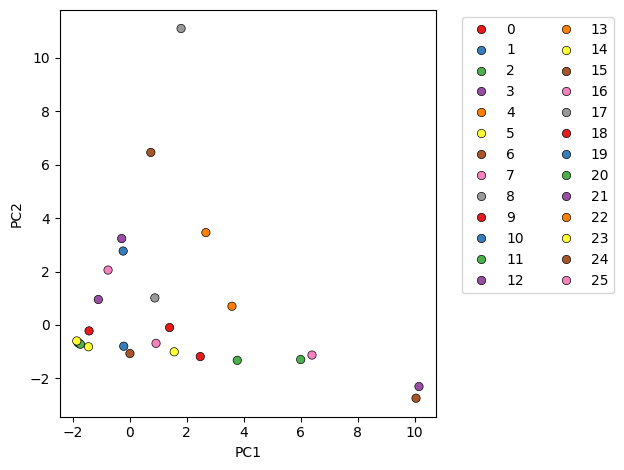

In [90]:
# Plot just the centroids
sns.scatterplot(
    x='PC1',
    y='PC2',
    hue='kmeans_cluster',
    palette='Set1',
    markers=1000,
    alpha=1,
    edgecolor="black",
    data=users_kmeans_centroids_df,
    legend=True
)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
plt.tight_layout()
plt.show()


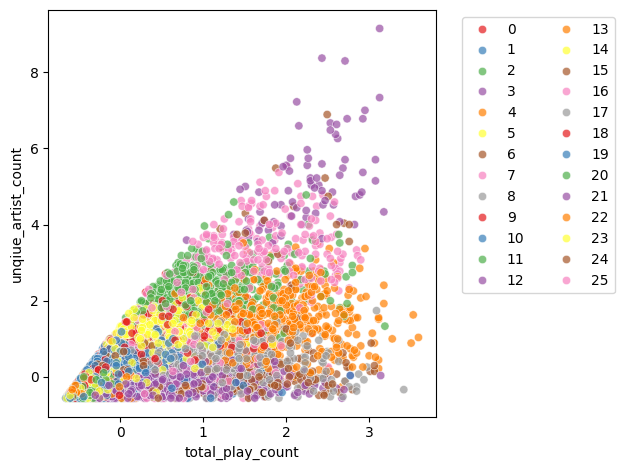

In [92]:
# To show that our current model is not separating just on play count and playtime
# We can see this because it is not neatly separated on these 2 features alone (like it was with just numerical values)
variable_pairs = ['total_play_count', 'unqiue_artist_count']
# Plotting the results
sns.scatterplot(
    x=variable_pairs[0],
    y=variable_pairs[1],
    hue='kmeans_cluster',
    palette='Set1',
    alpha=0.7,
    data=users_df_clusters_orig.sample(n=10000, random_state=RANDOM_STATE)
)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
plt.tight_layout()
plt.show()

## Model 2: HDBSCAN
Density based clustering

*   We noticed in a previous milestone that we had clusters with very few data points, so we wanted to try density based clustering to remedy this.
*   DBSCAN groups points that are closely packed together (many nearby neighbors)
*   Outliers in low-desnity regions are marked



Faizan's Colab (CPU with High RAM)

n= 100000

- x_map time: 1 minute
- hdbscan time: 93 sec


n= 200000
- x_map time: 130 sec
- hdbscan time:  458.84 seconds


n= 300000
- x_map time: 209.01 seconds
- hdbscan time:  1081.89 seconds

### Run HDBSCAN

In [ ]:
print("Starting HDBSCAN...")
start_time = time.time()

hdb_labels = HDBSCAN(
    min_cluster_size=200,  # of points in a group are valid to be a cluster, any less is noise
    min_samples=10,  # controls how strict "core" points are
    n_jobs=-1  # use all cores
).fit_predict(X_umap)

end_time = time.time()
print(f"HDBSCAN completed in {end_time - start_time:.2f} seconds")

Starting HDBSCAN...
HDBSCAN completed in 1482.40 seconds


In [ ]:
users_clustered_df["hdb_cluster"] = hdb_labels

In [ ]:
num_hdb_clusters = len(users_clustered_df["hdb_cluster"].unique())
print(num_hdb_clusters, "clusters")
users_clustered_df["hdb_cluster"].value_counts()
# 35k "-1"  with min_cluster_size=20, min_samples=10
# 36k "-1"  with min_cluster_size=20, min_samples=5

139 clusters


hdb_cluster
-1      151174
 82      53813
 73      44078
 65      35338
 45      15028
         ...  
 86        221
 15        217
 78        217
 84        211
 116       201
Name: count, Length: 139, dtype: int64

C:\Users\User\anaconda3\envs\music-recommender\Lib\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


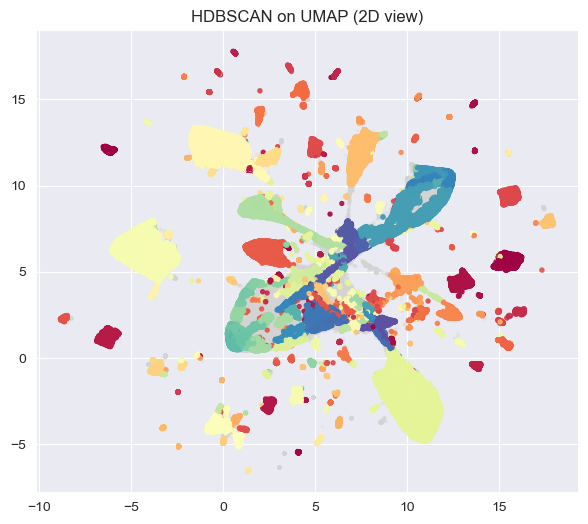

In [ ]:
# Plot the clusters similar to how its done for PCA space in k-means
X_umap_2d = UMAP(
    n_components=2,
    n_neighbors=30,
    min_dist=0.0,
).fit_transform(X_hdbscan)
plot_df = pd.DataFrame(X_umap_2d, columns=["UMAP1", "UMAP2"])
plot_df["hdb_cluster"] = hdb_labels

noise = plot_df[plot_df["hdb_cluster"] == -1]
clusters = plot_df[plot_df["hdb_cluster"] != -1]

plt.figure(figsize=(7, 6))

# noise first, light gray
plt.scatter(
    noise["UMAP1"], noise["UMAP2"],
    c="lightgray", s=2, alpha=0.15
)

# clusters on top
plt.scatter(
    clusters["UMAP1"], clusters["UMAP2"],
    c=clusters["hdb_cluster"], cmap="Spectral",
    s=8, alpha=0.9
)

plt.title("HDBSCAN on UMAP (2D view)")
plt.show()

### Evaluate HDBSCAN

<Axes: xlabel='hdb_cluster', ylabel='Count'>

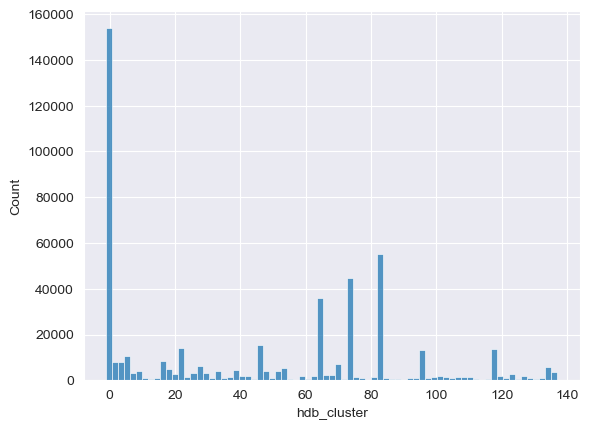

In [ ]:
sns.histplot(users_clustered_df['hdb_cluster'])

In [ ]:
hdf_clusters_inliers_df = users_clustered_df[users_clustered_df['hdb_cluster'] >= 0]
sns.histplot(hdf_clusters_inliers_df['hdb_cluster'])

In [ ]:
sns.pairplot(
    hue='hdb_cluster',
    palette='Set2',
    data=users_clustered_df.sample(
        n=1000,
        random_state=RANDOM_STATE
    )
)

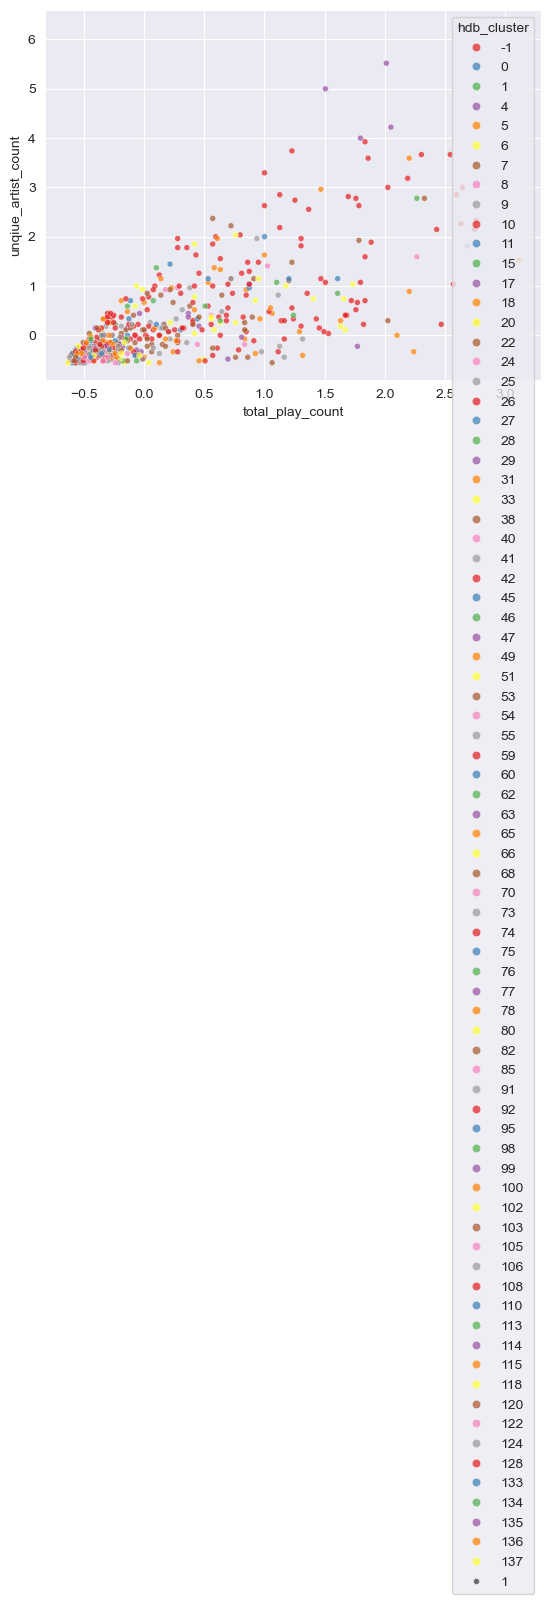

In [ ]:
# To show that our current model is not separating just on play count and play time
# We can see this because it is not neatly separated on these 2 features alone (like it was with just numerical values)
variable_pairs = ['total_play_count', 'unqiue_artist_count']
# Plotting the results
sns.scatterplot(
    x=variable_pairs[0],
    y=variable_pairs[1],
    hue='hdb_cluster',
    palette='Set1',
    alpha=0.7,
    data=users_clustered_df.sample(n=500, random_state=RANDOM_STATE)
)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=4)
plt.tight_layout()
plt.show()

### Save Cluster Assignments

In [ ]:
users_clustered_df.describe()

,total_play_count,total_play_time,unqiue_artist_count,unqiue_song_count,fav_maj_count,fav_min_count,fav_year,year_count,fav_song_plays,fav_song_duration,tot_fav_song_play_time,kmeans_cluster,hdb_cluster
count,503333.0,503333.0,503333.0,503333.0,503333.0,503333.0,503333.0,503333.0,503333.0,503333.0,503333.0,503333.000000,503333.000000
mean,0.258233,0.250797,0.332315,0.332315,0.381268,0.429538,-0.418806,0.275778,0.350608,0.139455,0.411173,11.687338,43.506909
std,0.790257,0.782589,0.984354,0.984354,1.117496,1.383465,1.181358,1.007237,1.240861,0.989274,1.25908,7.468183,41.110304
min,-0.658228,-0.627708,-0.555556,-0.555556,-0.8,-0.666667,-9.833333,-0.8,-0.636364,-2.723675,-0.70579,0.000000,-1.000000
25%,-0.35443,-0.355921,-0.333333,-0.333333,-0.333333,-0.333333,-0.666667,-0.4,-0.363636,-0.456641,-0.337585,4.000000,-1.000000
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.000000,45.000000
75%,0.64557,0.644079,0.666667,0.666667,0.666667,0.666667,0.333333,0.6,0.636364,0.543359,0.662415,19.000000,73.000000
max,7.56962,2.769254,9.37037,9.37037,15.866667,31.333333,0.666667,25.2,28.181818,4.776669,12.243311,25.000000,137.000000


In [ ]:
u_c_columns = ['user_id', 'hdb_cluster', 'kmeans_cluster']
users_clustered_df = users_clustered_df[u_c_columns]

In [ ]:
users_clustered_df.head()

,user_id,hdb_cluster,kmeans_cluster
0,00001cf0dce3fb22b0df0f3a1d9cd21e38385372,124,20
1,0000267bde1b3a70ea75cf2b2d216cb828e3202b,95,19
2,00004fb90a86beb8bed1e9e328f5d9b6ee7dc03e,99,1
3,00007ed2509128dcdd74ea3aac2363e24e9dc06b,82,1
4,0000bb531aaa657c932988bc2f7fd7fc1b2050ec,36,25


In [ ]:
# Save the processed dataframe to Parquet
users_clustered_df.to_parquet(users_clustered_path_parquet, index=False, engine='pyarrow')
print(f"Processed DataFrame saved to: {users_clustered_path_parquet}")

Processed DataFrame saved to: data/users_clusters_500k_df.parquet
